In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Synthetic data generation

In [2]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x: x

    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max = 1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N)) * x_max    
    else:
        x = np.linspace(0, x_max, N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [3]:
def visualize_data(y, y_true, x, title):
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(x[:, 0], y, edgecolor = 'b', label = "Noise data", s = 196, alpha = 0.6)
    plt.scatter(x[:, 0], y_true,label = "True data", s = 81, c = 'g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(fontsize=15)
    plt.title(title, fontsize=15)
    plt.xticks()
    plt.yticks();
    plt.tight_layout()
    plt.show()

### 1.1 Linear data

#### 1.1.1

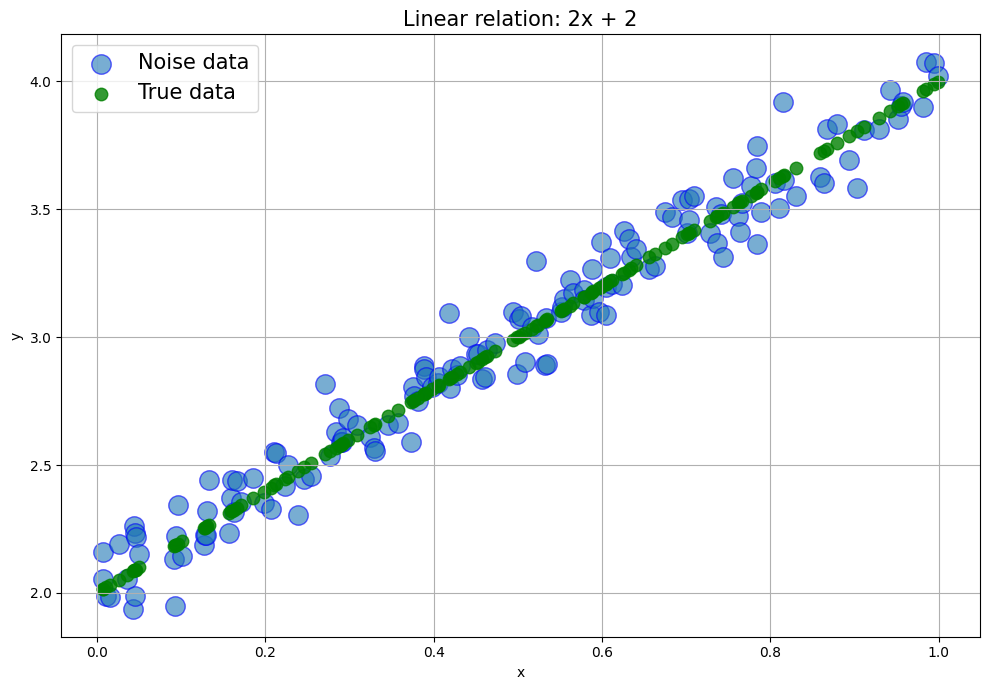

In [4]:
linear_1_y, linear_1_y_true, linear_1_x = dataset(
    a=2,
    b=2,
    f=None,
    N=150,
    x_max=1,
    noise_power=0.1,
    seed=32
)

visualize_data(linear_1_y, linear_1_y_true, linear_1_x, 'Linear relation: 2x + 2')

#### 1.1.2

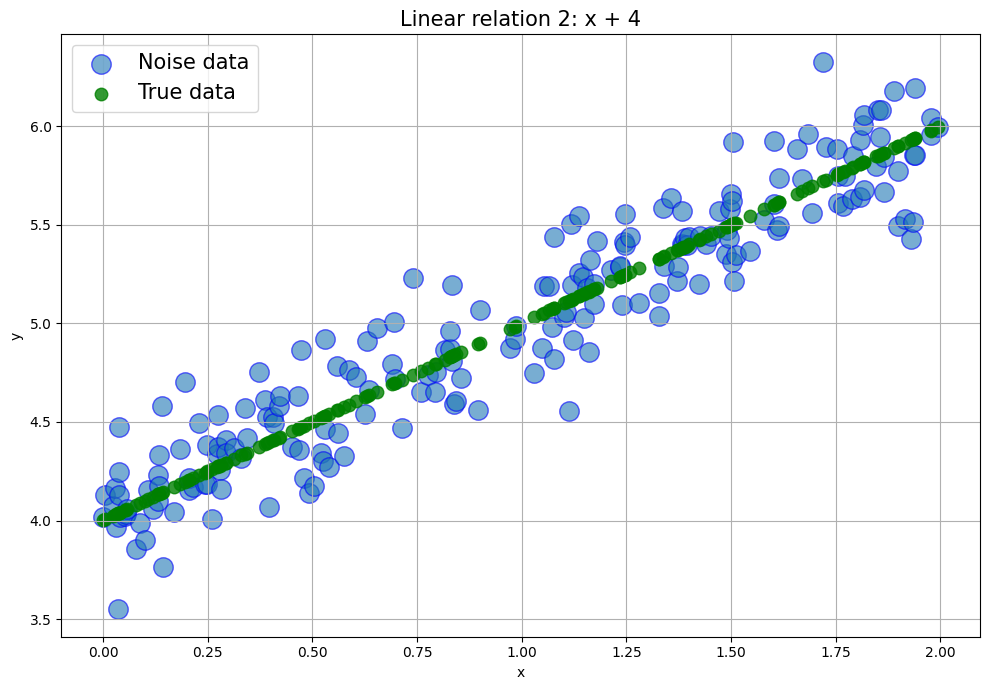

In [5]:
linear_2_y, linear_2_y_true, linear_2_x = dataset(
    a=1,
    b=4,
    f=None,
    N=200,
    x_max=2,
    noise_power=0.2,
    seed=1
)

visualize_data(linear_2_y, linear_2_y_true, linear_2_x, 'Linear relation 2: x + 4')

### 1.2 Sinusoidal relation

#### 1.2.1

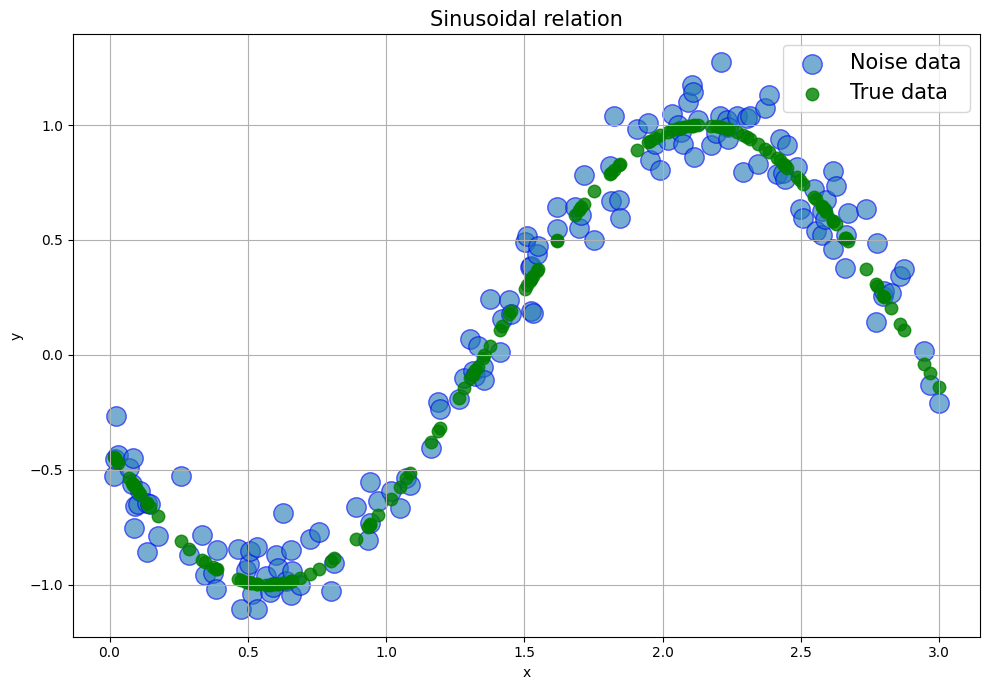

In [6]:
sinusoidal_y, sinusoidal_y_true, sinusoidal_x = dataset(
    a=2,
    b=2,
    f=np.cos,
    N=150,
    x_max=3,
    noise_power=0.1,
    seed=22
)

visualize_data(sinusoidal_y, sinusoidal_y_true, sinusoidal_x, 'Sinusoidal relation')

### 1.3 Polynomial data

#### 1.3.1

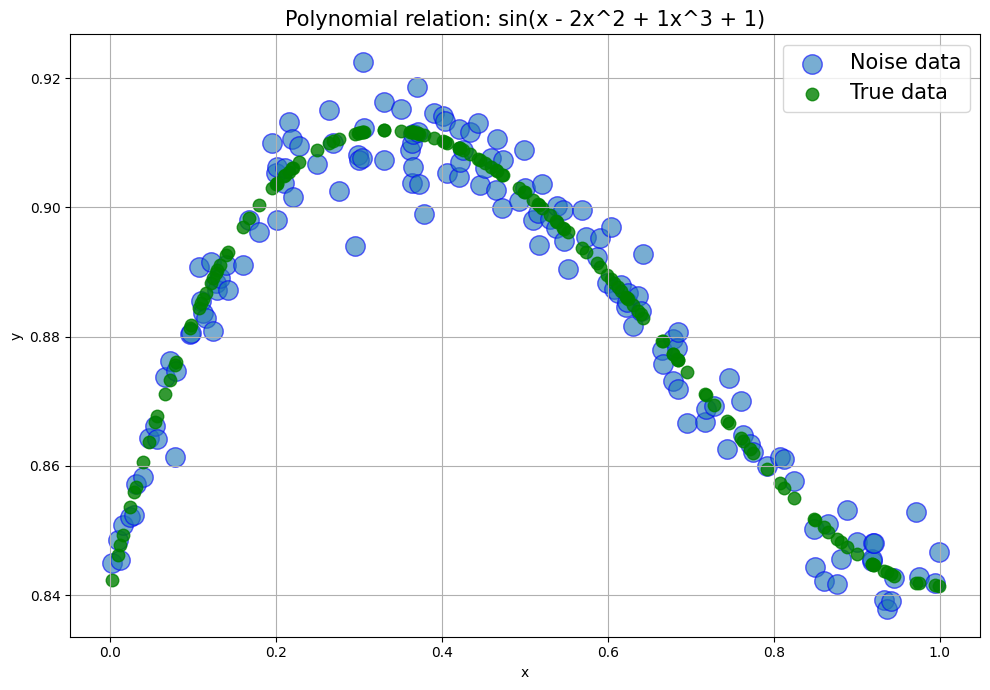

In [7]:
polynomial_1_y, polynomial_1_y_true, polynomial_1_x = dataset(
    a=[1, -2, 1],
    b=1,
    f=np.sin,
    N=150,
    x_max=1,
    noise_power=0.005,
    seed=15
)

visualize_data(polynomial_1_y, polynomial_1_y_true, polynomial_1_x, 'Polynomial relation: sin(x - 2x^2 + 1x^3 + 1)')

#### 1.3.2

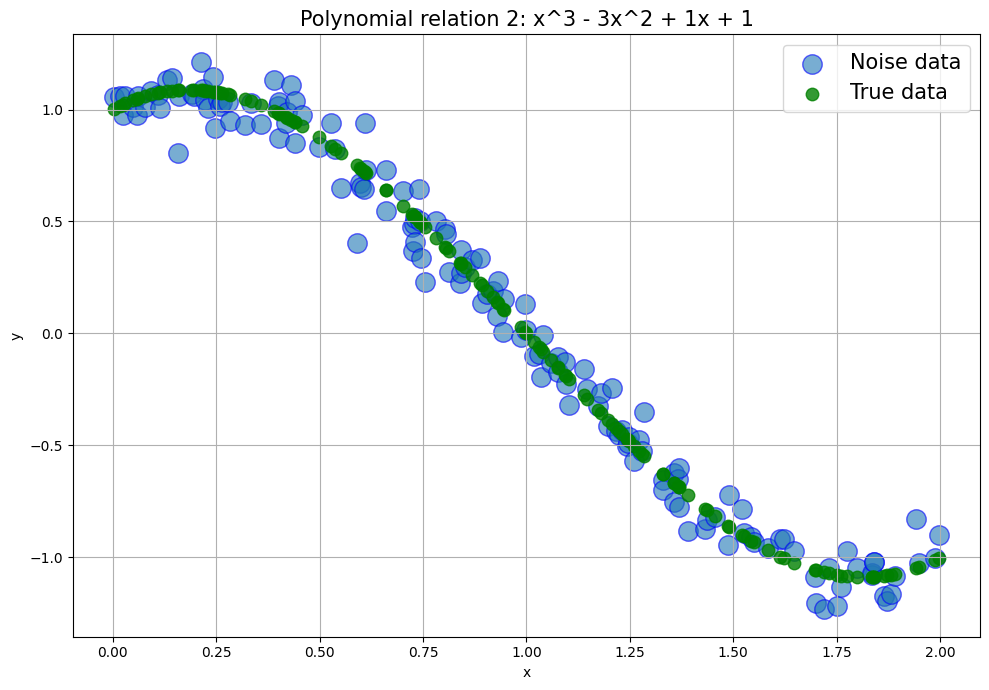

In [8]:
polynomial_2_y, polynomial_2_y_true, polynomial_2_x = dataset(
    a=[1, -3, 1],
    b=1,
    f=None,
    N=150,
    x_max=2,
    noise_power=0.1,
    seed=15
)

visualize_data(polynomial_2_y, polynomial_2_y_true, polynomial_2_x, 'Polynomial relation 2: x^3 - 3x^2 + 1x + 1')

#### 1.3.3

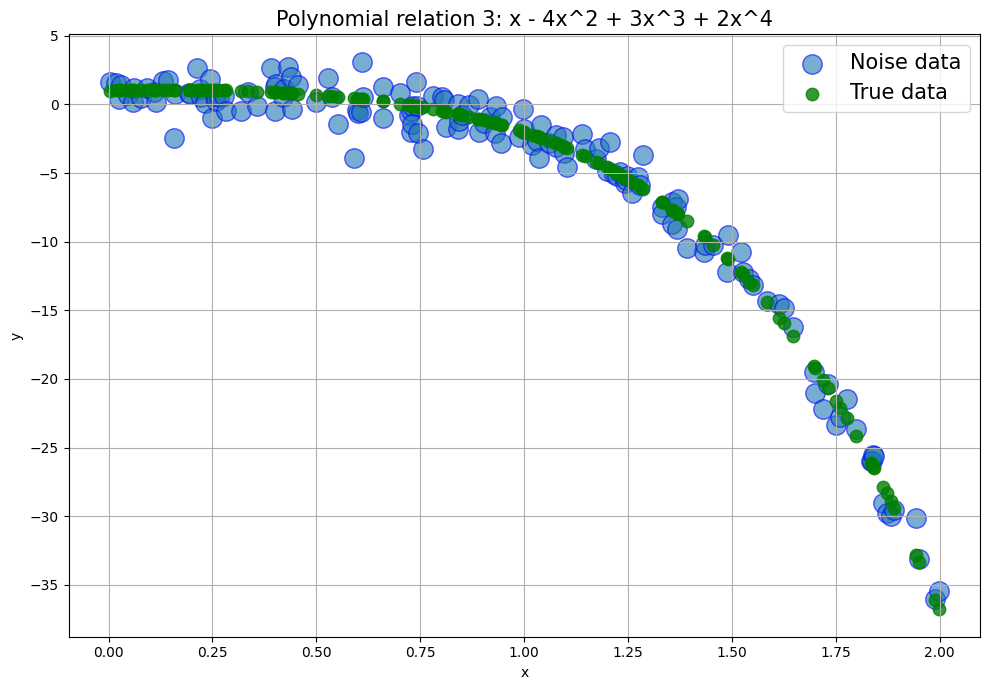

In [9]:
polynomial_3_y, polynomial_3_y_true, polynomial_3_x = dataset(
    a=[1, -4, 3, -3],
    b=1,
    f=None,
    N=150,
    x_max=2,
    noise_power=1.25,
    seed=15
)

visualize_data(polynomial_3_y, polynomial_3_y_true, polynomial_3_x, 'Polynomial relation 3: x - 4x^2 + 3x^3 + 2x^4')

### 2. 

In [10]:
def train_test_split(x, y, train_size=None, test_size=None, random_state=42, shuffle=True):
    if random_state:
        np.random.seed(random_state)

    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle:
        np.random.shuffle(idxs)

    if test_size and train_size is None:
        if (test_size <= 1):
            train_size = 1 - test_size
        else:
            train_size = size - test_size

        test_size = None   

    if train_size is None or train_size > size:
        train_size = size

    if (train_size <= 1):
        train_size *= size

    if test_size is not None: 
        if test_size <= 1:
            test_size *= size    

        if test_size > size:
            test_size = size - train_size
    else:
        test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val, y_val = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]

    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, x_val, x_test, y_train.squeeze(), y_val.squeeze(), y_test.squeeze() 

    return x_train, x_val, y_train.squeeze(), y_val.squeeze()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(linear_1_x, linear_1_y, test_size=0.3)    
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(105, 1) (105,) (45, 1) (45,)


In [12]:
def init_weights(W_shape, add_bias = True, random_state = 42):
    W_shape = np.atleast_1d(W_shape)
    if random_state:
        np.random.seed(random_state)
    W = np.random.randn(*list(W_shape)) / np.sqrt(np.sum(W_shape))
    if add_bias:
        W = np.column_stack((np.zeros(W.shape[-1]), W))
    return W.squeeze()

In [13]:
def predict( X, W, add_bias = True):
    """Предсказание линейной модели  
    Входные переменные:
    ===========
    X: признаки
    W: вектор весов
    add_bias: учитываем смещение или нет
    """
    if add_bias:
        X_full = np.column_stack((np.ones(X.shape[0]), X))
    else:
        X_full = X

    return  np.dot(X_full, W)

In [14]:
def loss_func(yhat, y):
    """функция потерь  
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """
    return np.square(yhat - y)  # функция потерь как квадрат разности предсказаний и реальных значений

##### x = linear_1_x y = linear_1_y

In [15]:
weights = init_weights(linear_1_x.shape[1]) # генерируем веса
yhat = predict(x_train[0], weights) # делаем предсказание на 1 точке
loss = loss_func(yhat, linear_1_y[0]) # посчитаем функцию потерь

print(f'Веса {weights}')

print(f'Первая точка-признак {x_train[0]},\nПредсказание {yhat},\nРеальное значение {linear_1_y[0]},\nФункция потерь: {loss}')

Веса [0.         0.49671415]
Первая точка-признак [0.47272312],
Предсказание [0.23480826],
Реальное значение [2.05260682],
Функция потерь: [3.30439159]


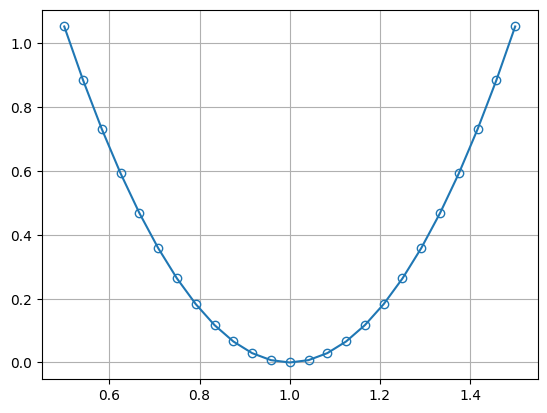

In [16]:
decline = np.linspace(start = 0.5, stop = 1.5, num = 25)
yhat = decline * linear_1_y[0]
loss = loss_func(yhat, linear_1_y[0])
plt.plot(decline, loss,'-o', mfc = 'none')
plt.grid()

In [17]:
def grad_loss(y_hat, y, X, add_bias = True):
    """Оценим градиент функции потерь  
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    X: признаки
    add_bias: учитываем смещение или нет
    """
    if add_bias: # если учитываем смещение
        X_full = np.column_stack((np.ones(X.shape[0]), X)) # добавляем единички по количеству точек данных
    else:
        X_full = X # иначе ничего не делаем
  
    return 2 * np.dot(X_full.T, (y_hat - y)) / y.size  # градиент функции потерь как среднее от матричного умножения признаков на разницу предсказание-реальное

In [18]:
yhat = predict(x_train[0], weights) # делаем предсказание на 1 точке

grad = grad_loss(yhat, linear_1_y[0], linear_1_x[0]) # делаем оценку градиента функции потерь
print(grad)

[-3.63559711 -0.02488869]


In [19]:
def update_weights(grad, W, learning_rate):
    """Обновим веса  
    Входные переменные:
    ===========
    grad: значение градиента
    W: веса
    learning_rate: скорость обучения
    """
    return W - learning_rate * grad # просто из старых весов вычитаем градиент помноженный на скорость обучения

In [20]:
learning_rate = 0.1
weights = update_weights(grad, weights, learning_rate)
print(weights)

[0.36355971 0.49920302]


In [21]:
yhat = predict(x_train[0], weights)
loss = loss_func(yhat, linear_1_y[0])

print(f'Веса {weights}')

print(f'Первая точка-признак {x_train[0]},\nПредсказание {yhat},\nРеальное значение {linear_1_y[0]},\nФункция потерь: {loss}')

Веса [0.36355971 0.49920302]
Первая точка-признак [0.47272312],
Предсказание [0.59954452],
Реальное значение [2.05260682],
Функция потерь: [2.11139005]


In [22]:
def fit(X, y, learning_rate, weights = None,  epochs=30):
    """Обучение модели.   
    Входные переменные:
    ===========
    X: признаки
    y: реальные значения
    learning_rate: скорость обучения
    weights: веса
    epochs: количество эпох обучения
    """

    if weights is None:
        weights = init_weights(X.shape[1])

    cost = np.zeros(epochs)

    for i in range(epochs):
        yhat = predict(X, weights)
        grad = grad_loss(yhat, y, X)
        weights = update_weights(grad, weights, learning_rate)
        cost[i] = loss_func(yhat, y).mean()
                
    return weights, cost

In [23]:
y_train

array([2.97624188, 2.22547107, 3.47990709, 2.90461752, 3.07104375,
       2.55189293, 2.87698773, 3.81300528, 2.93218376, 2.89248607,
       3.53558305, 2.1321448 , 2.44571309, 1.98955963, 2.22493671,
       2.88565696, 3.31381689, 2.93273226, 2.7493642 , 3.61263935,
       2.35250943, 3.7485505 , 2.4376755 , 3.48761285, 3.91998712,
       3.91720071, 3.48814665, 3.85304434, 2.68102554, 2.32639111,
       2.23268572, 2.34419542, 2.85373057, 2.15278021, 2.58950097,
       3.89926256, 2.66508312, 2.35734611, 2.18992194, 2.54655492,
       3.96650512, 3.0966445 , 3.11725904, 2.1435186 , 2.21727424,
       3.01238569, 3.55132451, 3.83488892, 2.85736938, 3.46877504,
       3.3725747 , 3.34486874, 2.88700597, 2.05260682, 3.410943  ,
       2.99890724, 2.45045828, 2.62780548, 2.60618076, 2.8189458 ,
       3.52529107, 2.44272972, 2.31747789, 2.37163209, 3.1532676 ,
       2.53466725, 3.09806595, 3.366802  , 2.61031703, 3.19500171,
       3.45839615, 2.4193705 , 3.69094615, 3.20238585, 3.09250

In [24]:
weights, cost = fit(x_train, y_train, learning_rate=0.1, epochs=10)

In [25]:
def plot_cost(cost):
    """Отрисовка функции потерь.   
    Входные переменные:
    ===========
    cost: функция потерь
    """
    # тут всё стандартно. просто график
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15);
    # с сеткой 
    plt.grid()
    # и подписаными осями
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция потерь",fontsize=35)
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);  

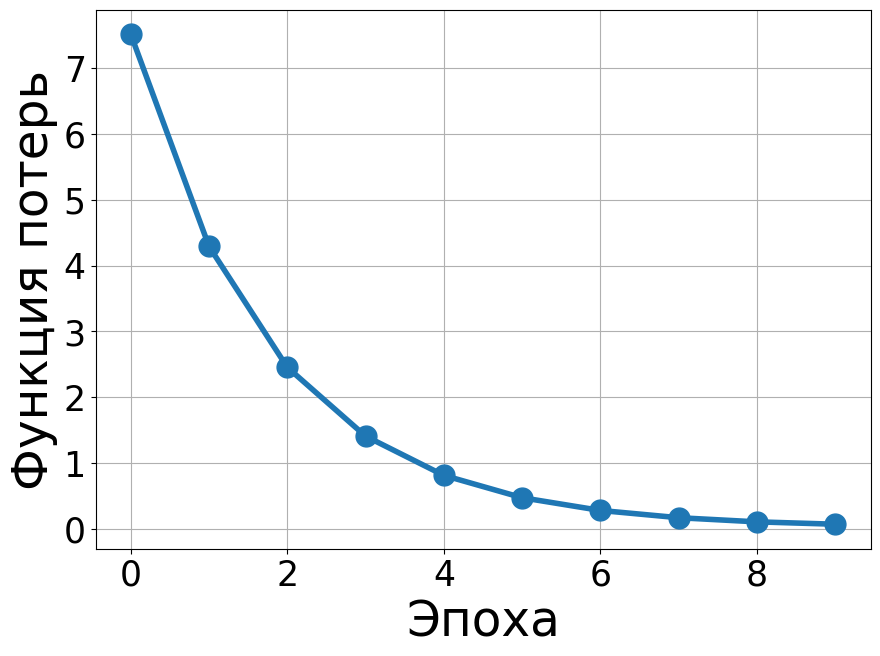

In [26]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

In [27]:
def r2_score(yhat, y):
    """Расчет коэффициента детерминации.   
    Входные переменные:
    ===========
    yhat: предсказание модели
    y: реальные значения
    """    
    return 1 - (np.square(y - yhat)).sum(axis=0) / (np.square(y - np.mean(y, axis=0))).sum(axis=0)

In [28]:
predicts = predict(x_test, weights)

r2_score(predicts, y_test), r2_score(predict(x_train, weights), y_train)

(0.8225123563853747, 0.8495011734361887)

In [29]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    """Отрисовка модели.   
    Входные переменные:
    ===========
    x_train: признаки на которых тренировались
    y_train: тренировочные целевые значения
    x_test: тестовые признаки
    x: полные признаки
    y: реальные целевые значения (без шума)
    weights: веса
    """

    # отдельно визуализируем
    # Предсказание на x_train
    #                           ↓ считаем предсказания с использованием написанное ранее функции predict
    plt.plot(x_train[:,0], predict(x_train,weights, ),
            '.', label='Предсказание на x_train',
            markersize = 15)
    # Предсказание на x_test
    plt.plot(x_test[:,0], predict(x_test,weights, ),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    # Тренировочные данные
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2, c='r')
    # Истинные Значения
    plt.plot(x[:,0], y, '--',
            label="Истинные значения", linewidth=4, c='g')
    # отличие в типе маркера, прозрачности и размере
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(fontsize = 25)
    plt.yticks(fontsize = 25);

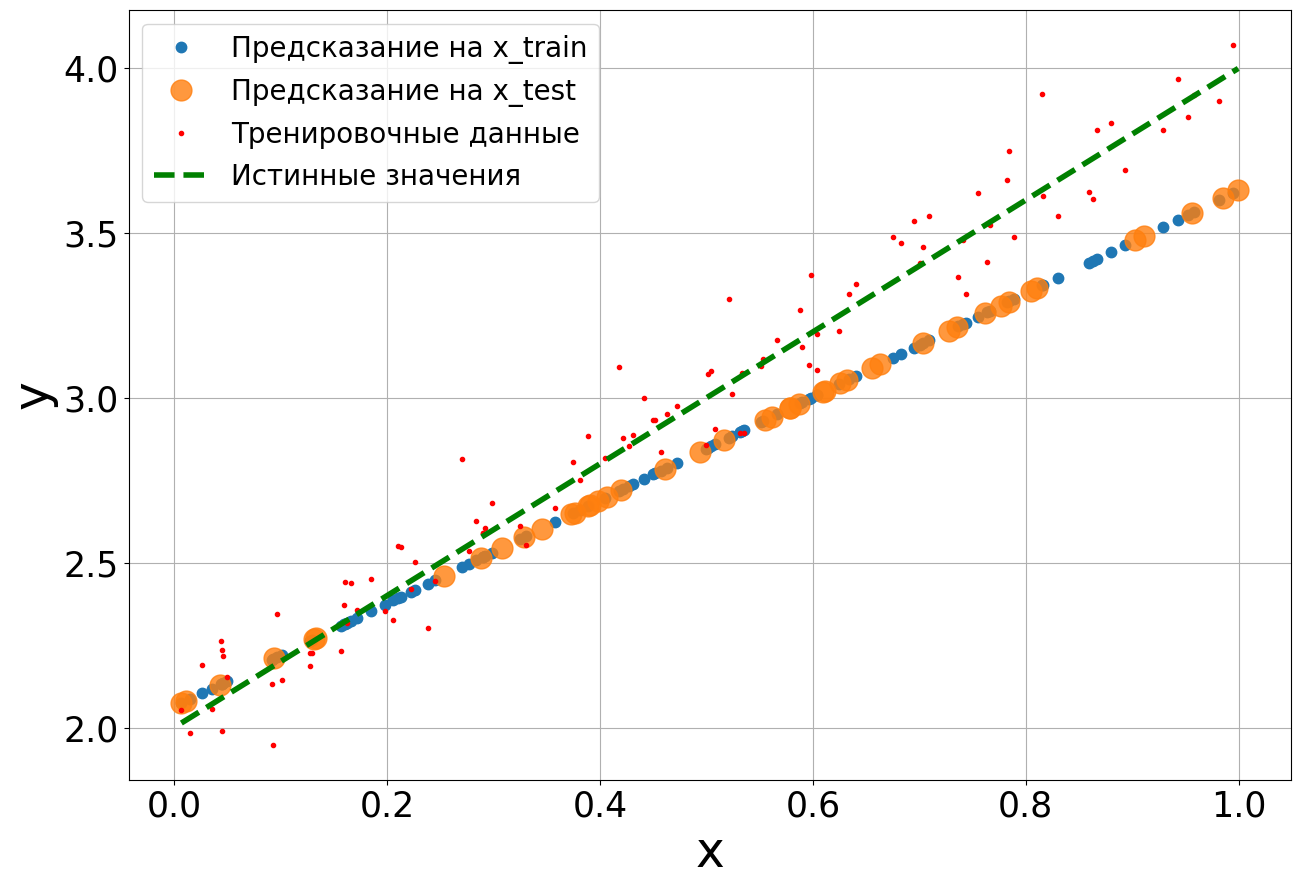

In [30]:
fig = plt.figure(figsize=(15, 10))

plot_model_weights(x_train, y_train, x_test, linear_1_x, linear_1_y_true, weights)

In [31]:
weights

array([2.06227784, 1.56830609])

In [32]:
def vis_weights(weights):
    numbers = np.arange(0, len(weights))
    tick_labels = ['w' + str(num) for num in numbers]
    cc = [''] * len(numbers)
    for n,val in enumerate(weights):
        if val < 0:
            cc[n] = 'red'
        elif val >= 0:
            cc[n] = 'blue'

    plt.bar(x = numbers, height = weights, color = cc) 
    plt.xticks(np.arange(0, len(weights)), tick_labels);

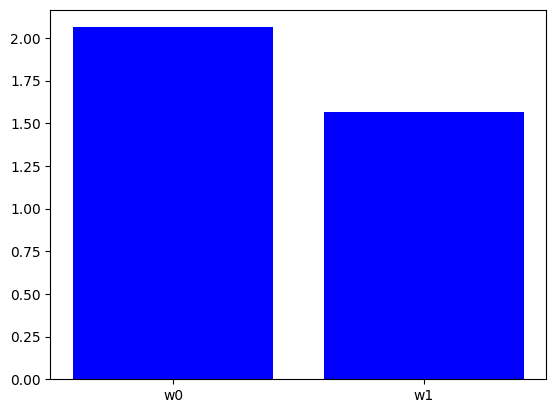

In [33]:
vis_weights(weights)

In [34]:
def load_batch(X,y, batch_size = 100):
    """загрузка батча.   
    Входные переменные:
    ===========
    X: признаки
    y: целевые переменные
    batch_size: размер батча
    """
    idxs = np.arange(y.size) # массив всех индексов
    np.random.shuffle(idxs) # перемешиваем индексы

    for i_batch in range(0,y.size,batch_size): # берем столько батчей, сколько "влезет" в размерность данных
        idx_batch = idxs[i_batch:i_batch+batch_size] # индексы текущего батча
        x_batch   = np.take(X, idx_batch,axis=0) # признаки в текущем батче
        y_batch   = np.take(y, idx_batch) # целевые переменные в текущем батче
        yield  x_batch, y_batch # возвращаем текущий батч
        # использование yield вместо return позволит на следущем вызове функции не запускать всё заново, а продолжить итерировать в цикле

In [35]:
BATCH = 10

def fit_SGD(X, y, learning_rate, weights = None,  epochs=30, batch_size = 100, random_state = 42):
    """Обучение модели с разбиением данных на батчи.   
    Входные переменные:
    ===========
    X: признаки
    y: реальные значения
    learning_rate: скорость обучения
    weights: веса
    epochs: количество эпох обучения
    batch_size: размер батча
    random_state: фиксированный сид случайных чисел (для повторяемости)  
    """
        
    if random_state: np.random.seed(random_state)# фиксируем случайный seed

    if weights is None: weights = init_weights(X.shape[1])# если веса не заданы - генерируем веса случайно
    # это если хотим продолжать обучение


    if batch_size is None or batch_size>y.size : batch_size = y.size  # "чиним" если размер батча не задан, или он больше количества данных
    n_batches = y.size//batch_size # считаем сколько батчей "влезет" в нашу выборку
    
    cost    = np.zeros(epochs) # создадим массив из нулей 

    for i in range(epochs): # цикл по количеству эпох
    # на каждом шаге
        loss = 0 #считаем функцию потерь в рамках отдельной эпохи
        for cnt,(x_batch, y_batch) in enumerate(load_batch(X,y, batch_size)): # перебираем данные по батчам 

            yhat    = predict(x_batch, weights) # делаем предсказание в рамках текущего батча
            grad    = grad_loss(yhat,  y_batch, x_batch) # считаем производную функции потерь в рамках текущего батча 
            weights = update_weights(grad, weights, learning_rate) # обновляем веса 
            loss   += loss_func(yhat,  y_batch).mean()# фиксируем среднее значение функции потерь в рамках текущего батча

            if cnt>= n_batches: # неполные батчи не учитываем)
                break 
        cost[i] = loss/n_batches # функция потерь как среднее от функций потерь на всех батчах в рамках эпохи

    return weights, cost #возвращаем итоговые веса (после epochs шагов обновлений) и график функции потерь.

In [36]:
weights = init_weights(x_train.shape[1], random_state=42)

weights, cost = fit_SGD(x_train, y_train, learning_rate=0.1, weights=weights, batch_size = 10,  epochs=10)

predicts = predict(x_test, weights)
r2_score(predicts, y_test), r2_score(predict(x_train,weights, ), y_train)

(0.9659674947264911, 0.9631037247368355)

In [37]:
weights

array([2.08607415, 1.89390602])

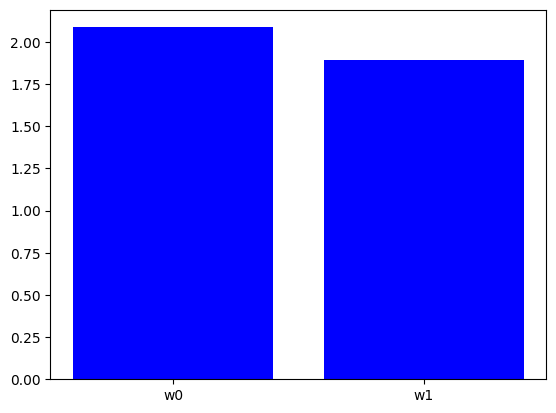

In [38]:
vis_weights(weights)

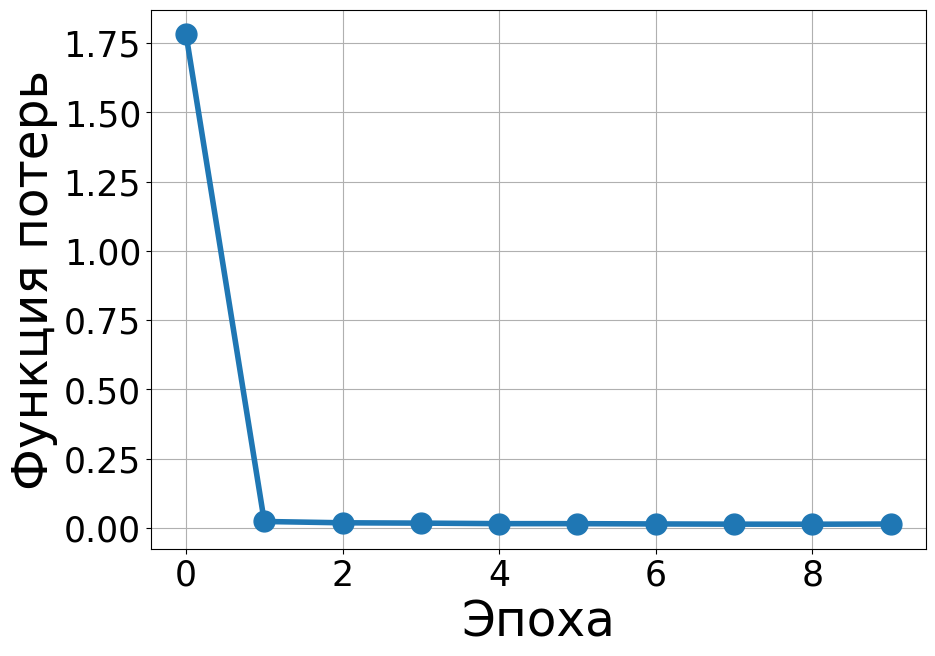

In [39]:
fig  = plt.figure(figsize=(10,7))

plot_cost(cost)

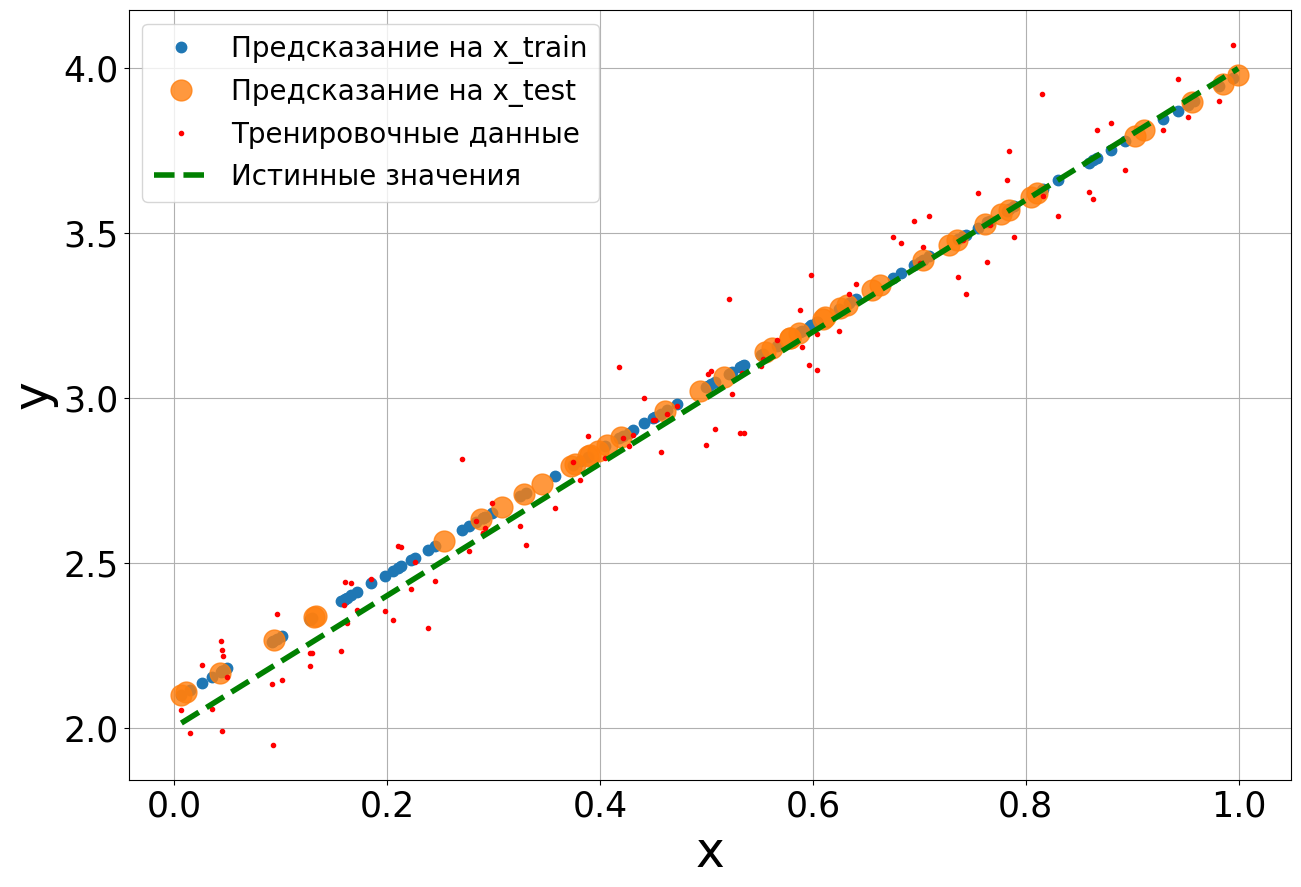

In [40]:
fig  = plt.figure(figsize=(15,10))

plot_model_weights(x_train, y_train, x_test, linear_1_x, linear_1_y_true, weights)

In [41]:
def run_all():
    return None

In [42]:
# class LinearRegression():
#     def __init__(self, 
#             learning_rate = 0.5, 
#             epochs = 100, 
#             weights = None, 
#             bias    = None, 
#             batch_size   = 1000,
#             n_batches    = None,
#             random_state = 42):
#         self.lr      = learning_rate
#         self.epochs  = epochs
#         self.weights = weights
#         self.bias    = bias
#         self.seed    = random_state
#         self.batch_size = batch_size
#         self.cost    = np.zeros(epochs)        
#         self.n_batches = n_batches
    
    
#     def forward(self, X):
#         return np.dot(X, self.weights)
    
#     def loss(self,yhat, y):
#         return np.square(yhat - y).sum()/y.size
    
#     def grad_step(self,yhat, y, X):
#         return 2*np.dot(X.T, (yhat - y)) / y.size
    
#     def update(self):    
#         return self.weights - self.lr*self.grad
    
#     def init(self, weights_size):
#         np.random.seed(self.seed)
#         return np.random.randn(weights_size)/np.sqrt(weights_size)
    
#     def predict(self, X):
#         yhat = self.forward(self.add_bias(X))
#         return yhat.squeeze()
    
#     def score(self, X, y):    
#         yhat = self.predict(X)
#         return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
#     def fit(self, X, y):
#         np.random.seed(self.seed)

#         if self.weights is None:
#             self.weights = self.init(X.shape[1])
        
#         if self.bias is None:
#             self.bias = self.init(1)
        
#         if self.weights.size == X.shape[1]:
#             self.weights = np.append(self.bias,self.weights)
        
#         self.grad = np.zeros(self.weights.shape)
#         self.cost = np.zeros(self.epochs)

#         if self.batch_size is None:  
#             self.batch_size = y.size
            
#         if self.n_batches is None:
#             self.n_batches = y.size//self.batch_size
            
#         for i in range(self.epochs):
#             loss = 0
#             for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

#                 yhat         = self.forward(x_batch)
#                 self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
#                 self.weights = self.update() 
#                 loss += self.loss(yhat,  y_batch)
                
#                 if cnt>= self.n_batches:
#                     break
#             self.cost[i] = loss/self.n_batches
        
#         self.bias = self.weights[0]

#     def load_batch(self,X,y):
#         idxs = np.arange(y.size)
#         np.random.shuffle(idxs)

#         for i_batch in range(0,y.size,self.batch_size):
#             idx_batch = idxs[i_batch:i_batch+self.batch_size]
#             x_batch   = np.take(X, idx_batch,axis=0)
#             x_batch   = self.add_bias(x_batch)
#             y_batch   = np.take(y, idx_batch)
#             yield  x_batch, y_batch
    
#     def add_bias(self, X):
#         return np.column_stack((np.ones(X.shape[0]), X))
   
#     def plot_cost(self, figsize = (12,6), title = ''):
#         plt.figure(figsize = figsize)
#         plt.plot(self.cost)
#         plt.grid()
#         plt.xlabel('Epoch', fontsize = 24)
#         plt.ylabel('Loss function', fontsize = 24)
#         plt.title(title, fontsize = 24)
#         plt.show()
   
#     def get_w_and_b(self):
#         return (self.weights[1:], self.bias)